In [2]:
import pandas as pd
file_path = '/Users/saifalikhan/Python-Anaconda/Ph.D. Work/Lumpy/Lumpy_data_updated.xlsx'
df = pd.read_excel(file_path)
df.head()

Country   Latitude  Longitude Reporting Date  Diagnosis.status
0  Afghanistan  35.541100  70.086200     2022-06-17                 1
1      Albania  41.531400  20.405000     2016-07-08                 1
2      Albania  41.915077  19.544564     2016-07-06                 1
3      Albania  41.233700  19.545900     2016-08-10                 1
4      Albania  41.233600  19.545900     2016-08-10                 1

In [4]:
# Count the number of cases in Diagnosis Status grouped by Country
country_case_counts = df.groupby('Country')['Diagnosis.status'].count().reset_index()

# Rename the column for clarity
country_case_counts = country_case_counts.rename(columns={'Diagnosis.status': 'Case Count'})

# Sort by case count in descending order and select the top 12 countries
top_12_countries = country_case_counts.sort_values(by='Case Count', ascending=False).head(10)

# Display the result
top_12_countries


Country  Case Count
50            Thailand         885
1              Albania         858
42  Russian Federation         486
30            Malaysia         320
22              Israel         247
51              Turkey         237
15              Greece         227
44              Serbia         223
7             Bulgaria         202
39     North Macedonia         186

/var/folders/j2/kkg5_g_s1jqcd1j6wyklb6rm0000gn/T/ipykernel_1249/712287553.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Reporting Date'] = pd.to_datetime(filtered_df['Reporting Date'])


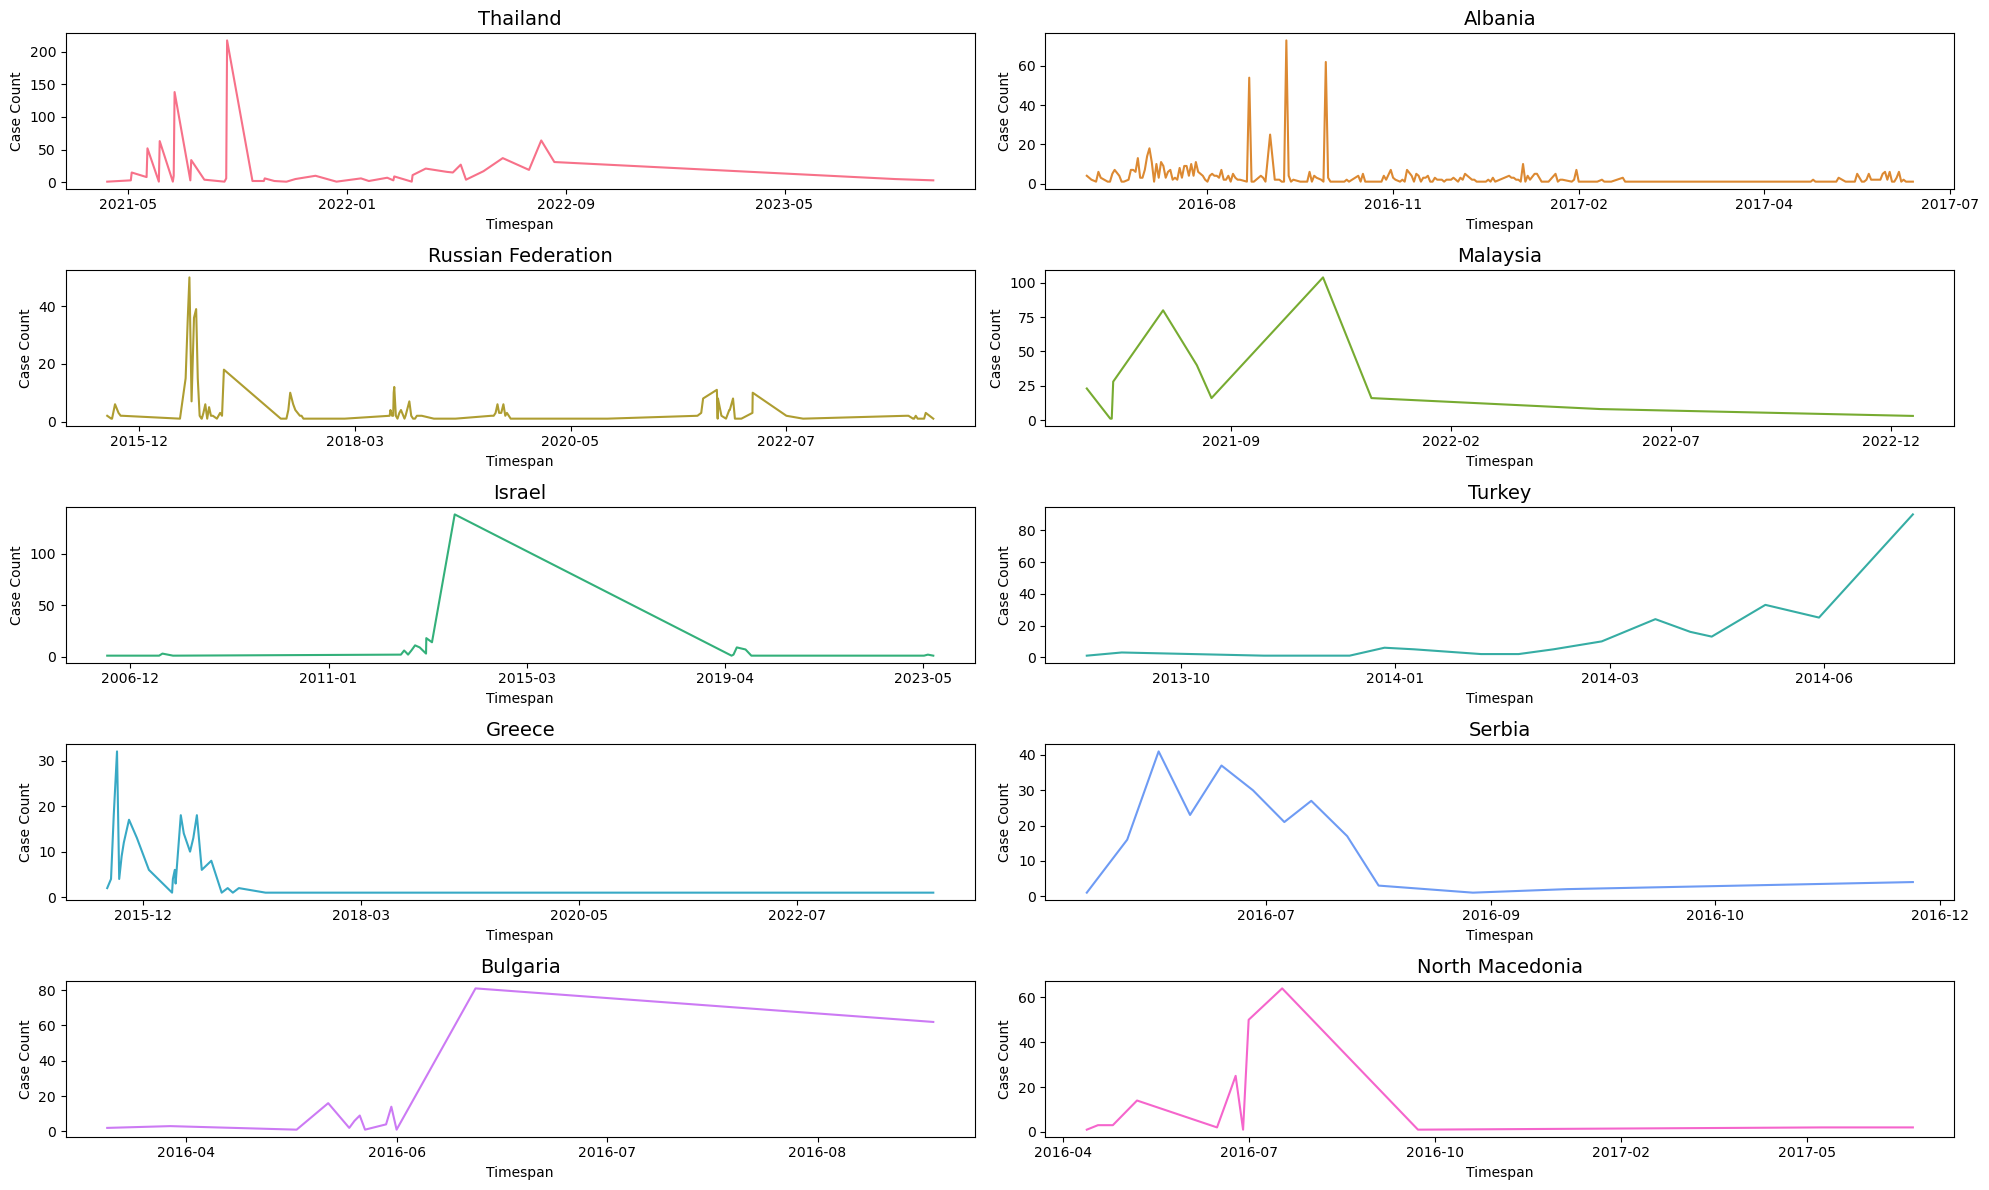

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
from matplotlib.ticker import MaxNLocator

# Filter the dataset for only the top 12 countries
top_countries = top_12_countries['Country'].tolist()
filtered_df = df[df['Country'].isin(top_countries)]

# Convert the 'report_date' column to datetime format for proper time series plotting
filtered_df['Reporting Date'] = pd.to_datetime(filtered_df['Reporting Date'])

# Group by Country and report_date to get the daily case counts
time_series_data = (
    filtered_df.groupby(['Country', 'Reporting Date'])
    .size()
    .reset_index(name='Case Count')
)

# Create subplots (3 rows x 4 columns)
fig, axes = plt.subplots(5, 2, figsize=(20, 12))  # Removed `sharex=True` for independent x-axis ranges
axes = axes.flatten()  # Flatten the 3x4 grid into a 1D array for easy iteration

# Generate a unique color palette for each country
custom_palette = sns.color_palette("husl", len(top_countries))

# Plot each country's time series in a separate subplot
for idx, country in enumerate(top_countries):
    ax = axes[idx]
    country_data = time_series_data[time_series_data['Country'] == country]
    
    sns.lineplot(
        data=country_data,
        x='Reporting Date',
        y='Case Count',
        ax=ax,
        color=custom_palette[idx]  # Assign a unique color for each country
    )
    
    # Format the x-axis to display only years
    ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
    ax.xaxis.set_major_locator(MaxNLocator(5))  # Ensure only 5 ticks are shown on the x-axis

    # Add title and labels to each subplot
    ax.set_title(country, fontsize=14)
    ax.set_xlabel("Timespan", fontsize=10)
    ax.set_ylabel("Case Count", fontsize=10)

# Remove empty subplots (if there are fewer than 12 countries)
for i in range(len(top_countries), len(axes)):
    fig.delaxes(axes[i])

# Adjust the layout
plt.tight_layout()
# Save the combined figure with bbox_to_anchor legend properly included
plt.savefig('trend_lumpy_data_by_country.png', dpi=500)
plt.show()


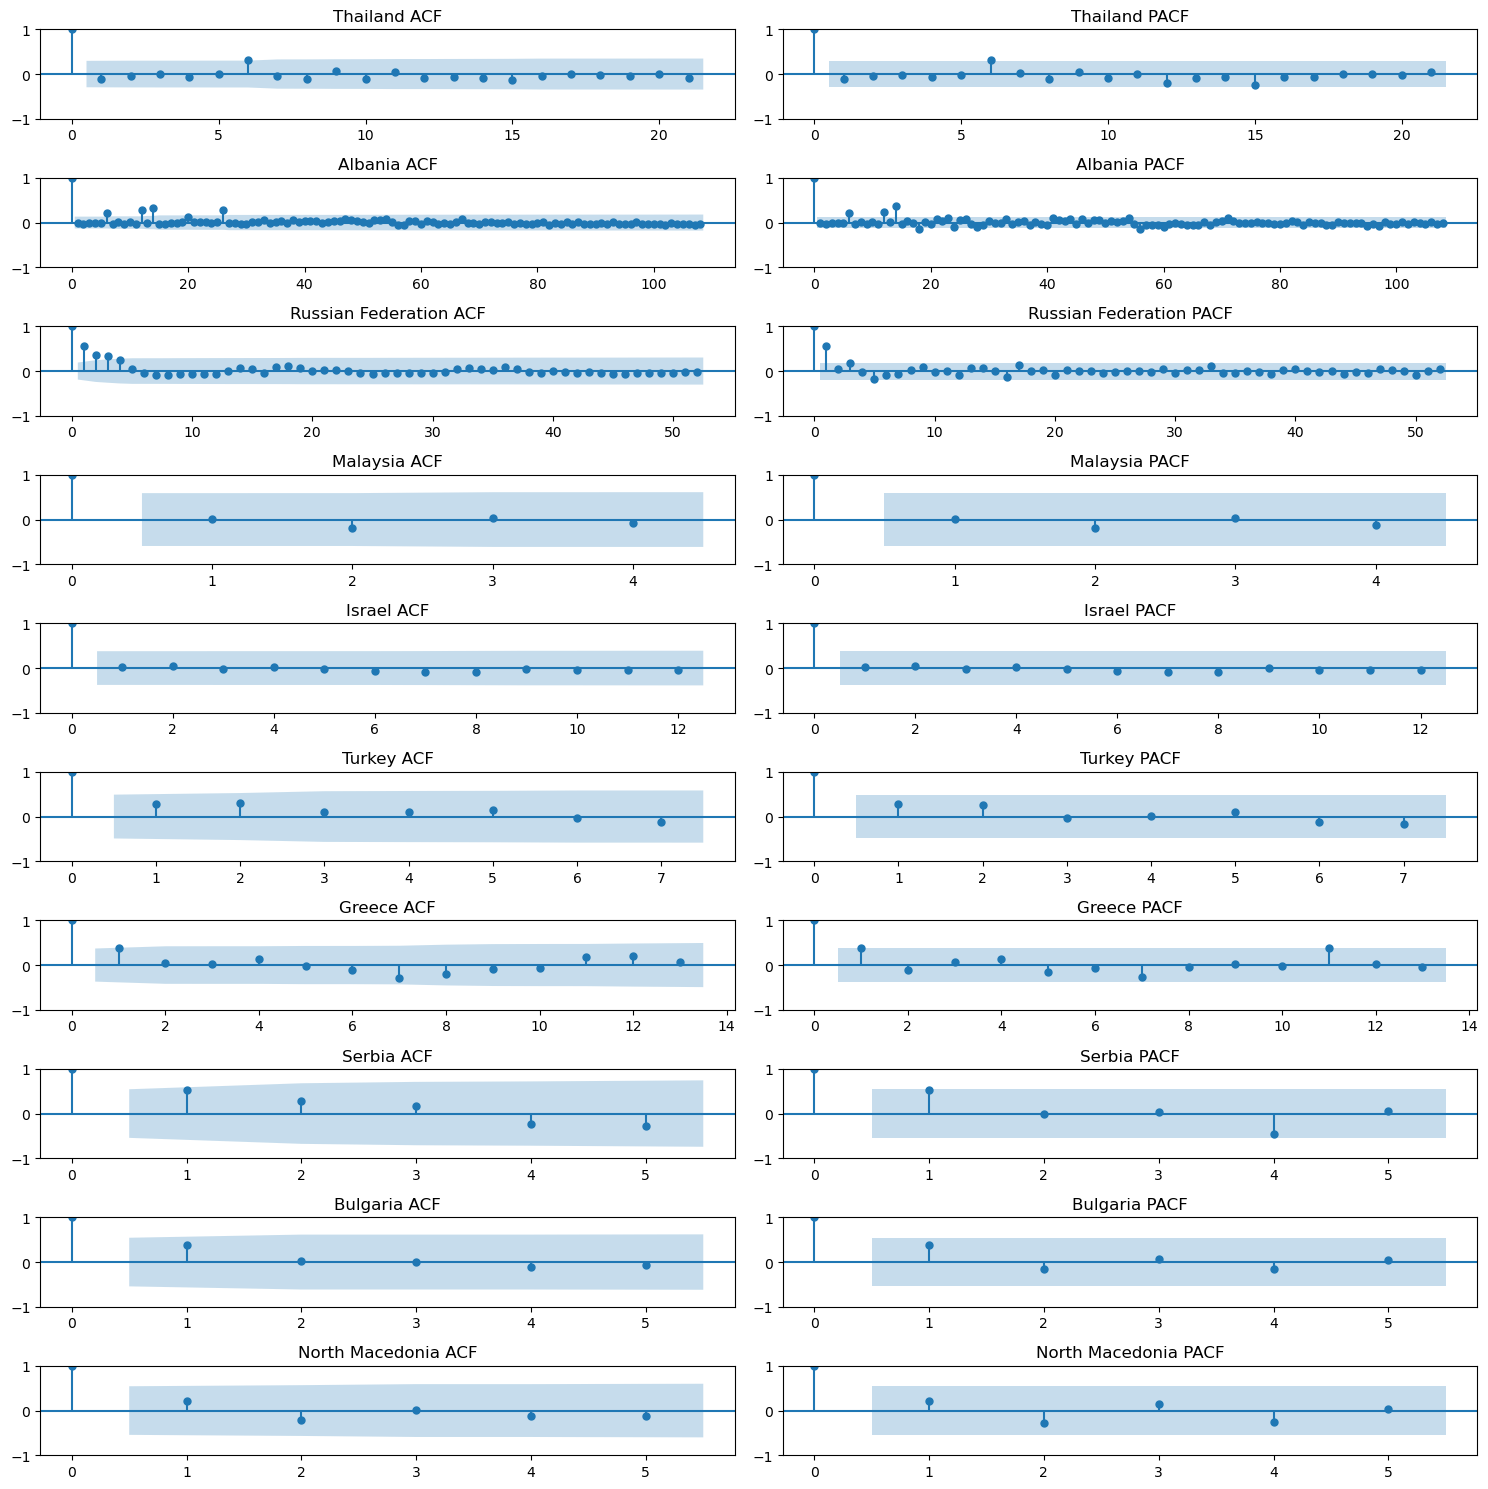

In [8]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame to store ADF test results
adf_results = []

# Create a single figure for ACF and PACF plots (10 rows x 2 columns)
fig, axs = plt.subplots(10, 2, figsize=(15, 15))  # 10x2 grid for ACF and PACF
axs = axs.reshape(10, 2)  # Ensure it is reshaped to (10, 2)

# Iterate over the top 10 countries and perform ADF test, plot ACF and PACF
for idx, country in enumerate(top_countries[:10]):  # Only top 10 countries
    country_data = time_series_data[time_series_data['Country'] == country]
    
    # Perform ADF test
    daily_cases = country_data.groupby('Reporting Date')['Case Count'].sum()
    
    # ADF test results
    adf_result = adfuller(daily_cases)
    stationary = adf_result[1] < 0.05  # If p-value < 0.05, the series is stationary
    
    # Store ADF test results
    adf_results.append({
        'Country': country,
        'ADF Statistic': adf_result[0],
        'p-value': adf_result[1],
        'Stationary': 'Yes' if stationary else 'No'
    })
    
    # Determine maximum lags based on the length of the time series
    max_lags = max(1, len(daily_cases) // 2 - 1)  # Ensure at least 1 lag and up to half of the data points
    
    # Plot ACF and PACF with the appropriate number of lags
    plot_acf(daily_cases, ax=axs[idx, 0], lags=max_lags)
    plot_pacf(daily_cases, ax=axs[idx, 1], lags=max_lags)
    
    # Add titles to ACF and PACF plots
    axs[idx, 0].set_title(f'{country} ACF', fontsize=12)
    axs[idx, 1].set_title(f'{country} PACF', fontsize=12)

# Adjust layout for the combined figure
fig.tight_layout()

# Display ADF test results as a DataFrame
adf_results_df = pd.DataFrame(adf_results)

# Show the combined figure
plt.show()


# Model Comparison

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from matplotlib.ticker import MaxNLocator

# Function to train and predict with AutoARIMA model
def train_predict_autoarima(train_data, test_data):
    model = auto_arima(train_data, seasonal=True, suppress_warnings=True, stepwise=True, error_action='ignore', max_d=2)
    forecast = model.predict(n_periods=len(test_data))
    mse = mean_squared_error(test_data, forecast)
    return forecast, mse

# Function to train and predict with Decision Tree model
def train_predict_decision_tree(X_train, y_train, X_test):
    model = DecisionTreeRegressor()
    model.fit(X_train, y_train)
    forecast = model.predict(X_test)
    mse = mean_squared_error(y_test, forecast)  # Assuming y_test is available globally
    return forecast, mse

# Function to train and predict with Random Forest model
def train_predict_random_forest(X_train, y_train, X_test):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    forecast = model.predict(X_test)
    mse = mean_squared_error(y_test, forecast)  # Assuming y_test is available globally
    return forecast, mse

# Function to train and predict with SVR model
def train_predict_svr(X_train, y_train, X_test):
    model = SVR(kernel='rbf', C=100, gamma='scale')
    model.fit(X_train, y_train)
    forecast = model.predict(X_test)
    mse = mean_squared_error(y_test, forecast)  # Assuming y_test is available globally
    return forecast, mse

# Function to plot results without creating a gap between train and test data
def plot_results(ax, train_data, test_data, forecast, title):
    # Combine train and test data into one series for continuity
    combined_data = pd.concat([train_data, test_data])
    
    # Plot the full actual data (train + test) as a continuous line
    ax.plot(combined_data.index, combined_data.values, label='Actual', color='blue', linestyle='--')
    
    # Highlight the train and test regions
    ax.plot(train_data.index, train_data.values, label='Train', color='blue', linestyle='--')
    ax.plot(test_data.index, test_data.values, label='Test', color='orange', linestyle='--')
    
    # Plot forecasted data
    ax.plot(test_data.index, forecast, label='Forecast', color='green')
    
    # Add titles and labels
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel('Date', fontweight='bold')
    ax.set_ylabel('Lumpy Cases', fontweight='bold')
    ax.xaxis.set_major_locator(MaxNLocator(nbins=4))
    ax.tick_params(axis='x', rotation=0)
    return ax

# Load your data
df = pd.read_excel('/Users/saifalikhan/Python-Anaconda/Ph.D. Work/Lumpy/Lumpy_data_updated.xlsx', parse_dates=['Reporting Date'])

# Get the top 10 countries based on total Diagnosis.status
top_countries = df.groupby('Country')['Diagnosis.status'].sum().nlargest(10).index

# Create an empty list to store combined results as dictionaries
combined_results = []

# Create subplots for all models
fig, axs = plt.subplots(10, 4, figsize=(20, 18), dpi=500)
axs = axs.flatten()

models = ['AutoARIMA', 'Decision Tree', 'Random Forest', 'SVR']
model_functions = [train_predict_autoarima, train_predict_decision_tree, train_predict_random_forest, train_predict_svr]

# Variables to store lines for legend
train_lines = []
test_lines = []
forecast_lines = []

for i, country in enumerate(top_countries):
    country_data = df[df['Country'] == country]
    country_data = country_data.sort_values('Reporting Date')
    
    # Create a DataFrame with the daily sum of cases per date
    daily_cases = country_data.groupby('Reporting Date')['Diagnosis.status'].sum()
    
    # Create lagged features for tree-based and SVR models
    lags = 5
    data = pd.DataFrame({'y': daily_cases})
    for lag in range(1, lags + 1):
        data[f'lag_{lag}'] = data['y'].shift(lag)
    data = data.dropna()
    
    # Split data into train and test sets
    X = data.drop(columns=['y'])
    y = data['y']
    train_size = int(0.8 * len(data))
    X_train, X_test, y_train, y_test = X.iloc[:train_size], X.iloc[train_size:], y.iloc[:train_size], y.iloc[train_size:]
    
    try:
        for j, (model_name, model_func) in enumerate(zip(models, model_functions)):
            if model_name == 'AutoARIMA':
                forecast, mse = model_func(y_train, y_test)
            else:
                forecast, mse = model_func(X_train, y_train, X_test)
            
            plot_results(axs[i * len(models) + j], y_train, y_test, forecast, f'{country} - {model_name}')
            
            combined_results.append({
                'Country': country,
                'Model': model_name,
                'MSE': mse,
                'Forecast': forecast.tolist()
            })
            
            # Collect lines for legend
            if i == 0 and j == 0:
                train_lines.append(axs[i * len(models) + j].lines[1])  # Train line
                test_lines.append(axs[i * len(models) + j].lines[2])   # Test line
                forecast_lines.append(axs[i * len(models) + j].lines[3])  # Forecast line
            
    except Exception as e:
        print(f"Error occurred while processing {country}: {e}")

# Adjust layout
plt.tight_layout()

# Create a single legend
fig.legend(handles=[train_lines[0], test_lines[0], forecast_lines[0]], labels=['Train', 'Test', 'Forecast'],
           loc='upper right', bbox_to_anchor=(1.04, 0.98), fontsize='large')

# Save the combined figure with bbox_to_anchor legend properly included
#plt.savefig('combined_forecast_plots.png', bbox_inches='tight', dpi=500)
#plt.savefig('combined_forecast_plots.pdf', bbox_inches='tight', dpi=500)


# Convert combined_results list of dictionaries to DataFrame
combined_results_df = pd.DataFrame(combined_results)

# Save combined results to Excel
#combined_results_df.to_excel("combined_results.xlsx", index=False)

plt.show()


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_pred

In [12]:
combined_results_df

Country          Model          MSE  \
0             Thailand      AutoARIMA   389.819719   
1             Thailand  Decision Tree   670.375000   
2             Thailand  Random Forest   873.098688   
3             Thailand            SVR   601.680888   
4              Albania      AutoARIMA     3.159554   
5              Albania  Decision Tree   499.296512   
6              Albania  Random Forest    37.198118   
7              Albania            SVR     2.886395   
8   Russian Federation      AutoARIMA     6.483856   
9   Russian Federation  Decision Tree    21.523810   
10  Russian Federation  Random Forest     7.128758   
11  Russian Federation            SVR     6.001885   
12            Malaysia      AutoARIMA  2310.494451   
13            Malaysia  Decision Tree  9708.500000   
14            Malaysia  Random Forest  3041.146400   
15            Malaysia            SVR  3775.559882   
16              Israel      AutoARIMA   129.303806   
17              Israel  Decision Tree  3830.800000   
18              Israel  Random Forest   452.771162   
19              Israel            SVR    39.725999   
20              Turkey      AutoARIMA  2350.954838   
21              Turkey  Decision Tree  2157.666667   
22              Turkey  Random Forest  1902.880267   
23              Turkey            SVR  2239.152284   
24              Greece      AutoARIMA    44.853356   
25              Greece  Decision Tree   125.600000   
26              Greece  Random Forest    91.923000   
27              Greece            SVR   207.944480   
28              Serbia      AutoARIMA     5.679468   
29              Serbia  Decision Tree     5.000000   
30              Serbia  Random Forest     8.933450   
31              Serbia            SVR   103.864916   
32            Bulgaria      AutoARIMA  4402.361111   
33            Bulgaria  Decision Tree  4116.500000   
34            Bulgaria  Random Forest  4230.864650   
35            Bulgaria            SVR  4486.316496   
36     North Macedonia      AutoARIMA   600.250000   
37     North Macedonia  Decision Tree  3074.000000   
38     North Macedonia  Random Forest  2143.700800   
39     North Macedonia            SVR  1044.022776   

                                             Forecast  
0   [20.193548387096776, 20.193548387096776, 20.19...  
1      [15.0, 34.0, 1.0, 1.0, 15.0, 15.0, 15.0, 27.0]  
2   [26.92, 23.38, 33.28, 42.13, 14.43, 26.6, 43.9...  
3   [20.25801777816033, 27.801413354677976, 20.572...  
4   [2.81552845493964, 2.81552845493964, 2.8155284...  
5   [7.0, 3.5, 73.0, 7.0, 3.5, 73.0, 1.0, 1.0, 1.5...  
6   [3.88, 3.6793333333333336, 23.046666666666667,...  
7   [2.907333973338269, 2.0522755352814923, 1.8097...  
8   [2.075926875633179, 2.6288174898199506, 2.9129...  
9   [1.0, 2.0, 1.0, 11.0, 5.0, 1.0, 1.0, 2.0, 8.0,...  
10  [2.742857142857143, 3.63, 2.74, 4.67, 4.09, 2....  
11  [1.8172090672201708, 3.5045695961905334, 1.471...  
12            [67.84943166309522, 35.234057013144124]  
13                                     [104.0, 104.0]  
14                                     [54.08, 65.92]  
15             [40.128374906021904, 83.7396265131629]  
16  [13.529411764705882, 13.529411764705882, 13.52...  
17                      [9.0, 138.0, 6.0, 18.0, 11.0]  
18  [39.294000000000004, 29.304000000000002, 4.433...  
19  [6.239067149015349, 6.167661762347014, 8.53680...  
20  [11.46978661514648, 10.603135526593087, 10.112...  
21                                 [13.0, 13.0, 13.0]  
22                               [17.32, 17.22, 16.5]  
23  [12.202482891023855, 11.813200527917195, 11.82...  
24  [6.002525526817746, 7.615449391974486, 8.26541...  
25                       [6.0, 18.0, 4.0, 14.0, 14.0]  
26                  [7.18, 9.58, 10.13, 12.87, 12.82]  
27  [9.294675546585164, 10.180458043512832, 15.032...  
28            [0.901984456989138, 0.8135759606499902]  
29                                         [3.0, 1.0]  
30                                        [6.13, 4.9]  
31      

# Cross validation

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from matplotlib.ticker import MaxNLocator

# AutoARIMA forecast
def train_predict_autoarima(train_data, test_data):
    model = auto_arima(train_data, seasonal=True, suppress_warnings=True, stepwise=True, error_action='ignore', max_d=2)
    forecast = model.predict(n_periods=len(test_data))
    mse = mean_squared_error(test_data, forecast)
    return forecast, mse

# Decision Tree with fixed hyperparameters
def train_predict_decision_tree(X_train, y_train, X_test, y_test):
    param_grid = {
        'max_depth': [3, 5, 10, None],
        'min_samples_leaf': [1, 2, 4, 6]
    }

    tscv = TimeSeriesSplit(n_splits=5)
    dt = DecisionTreeRegressor(random_state=42)
    grid_search = GridSearchCV(dt, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    print(f"Best Decision Tree params: {grid_search.best_params_}")

    forecast = best_model.predict(X_test)
    mse = mean_squared_error(y_test, forecast)
    return forecast, mse


# Random Forest with hyperparameter tuning using time series CV
def train_predict_random_forest(X_train, y_train, X_test, y_test):
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 10, None],
        'min_samples_leaf': [1, 2, 4]
    }

    tscv = TimeSeriesSplit(n_splits=5)
    rf = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(rf, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    
    print(f"Best Random Forest params: {grid_search.best_params_}")
    
    forecast = best_model.predict(X_test)
    mse = mean_squared_error(y_test, forecast)
    return forecast, mse

# SVR
def train_predict_svr(X_train, y_train, X_test, y_test):
    model = SVR(kernel='rbf', C=100, gamma='scale')
    model.fit(X_train, y_train)
    forecast = model.predict(X_test)
    mse = mean_squared_error(y_test, forecast)
    return forecast, mse

# Plotting
def plot_results(ax, train_data, test_data, forecast, title):
    combined_data = pd.concat([train_data, test_data])
    ax.plot(combined_data.index, combined_data.values, label='Actual', color='blue', linestyle='--')
    ax.plot(train_data.index, train_data.values, label='Train', color='blue', linestyle='--')
    ax.plot(test_data.index, test_data.values, label='Test', color='orange', linestyle='--')
    ax.plot(test_data.index, forecast, label='Forecast', color='green')
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel('Date', fontweight='bold')
    ax.set_ylabel('Lumpy Cases', fontweight='bold')
    ax.xaxis.set_major_locator(MaxNLocator(nbins=4))
    ax.tick_params(axis='x', rotation=0)
    return ax

# Load data
df = pd.read_excel('/Users/saifalikhan/Python-Anaconda/Ph.D. Work/Lumpy/Lumpy_data_updated.xlsx', parse_dates=['Reporting Date'])

# Get top 10 countries by cases
top_countries = df.groupby('Country')['Diagnosis.status'].sum().nlargest(10).index

# Results and figure
combined_results = []
fig, axs = plt.subplots(10, 4, figsize=(20, 18), dpi=500)
axs = axs.flatten()

models = ['AutoARIMA', 'Decision Tree', 'Random Forest', 'SVR']
model_functions = [
    lambda yt, yv, *_: train_predict_autoarima(yt, yv),
    train_predict_decision_tree,
    train_predict_random_forest,
    train_predict_svr
]

train_lines, test_lines, forecast_lines = [], [], []

for i, country in enumerate(top_countries):
    country_data = df[df['Country'] == country].sort_values('Reporting Date')
    daily_cases = country_data.groupby('Reporting Date')['Diagnosis.status'].sum()
    
    lags = 5
    data = pd.DataFrame({'y': daily_cases})
    for lag in range(1, lags + 1):
        data[f'lag_{lag}'] = data['y'].shift(lag)
    data = data.dropna()

    X = data.drop(columns=['y'])
    y = data['y']
    train_size = int(0.8 * len(data))
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

    try:
        for j, (model_name, model_func) in enumerate(zip(models, model_functions)):
            if model_name == 'AutoARIMA':
                forecast, mse = model_func(y_train, y_test)
            else:
                forecast, mse = model_func(X_train, y_train, X_test, y_test)
            
            plot_results(axs[i * len(models) + j], y_train, y_test, forecast, f'{country} - {model_name}')
            combined_results.append({
                'Country': country,
                'Model': model_name,
                'MSE': mse,
                'Forecast': forecast.tolist()
            })

            if i == 0 and j == 0:
                train_lines.append(axs[i * len(models) + j].lines[1])
                test_lines.append(axs[i * len(models) + j].lines[2])
                forecast_lines.append(axs[i * len(models) + j].lines[3])

    except Exception as e:
        print(f"Error processing {country} with {model_name}: {e}")

plt.tight_layout()
fig.legend(handles=[train_lines[0], test_lines[0], forecast_lines[0]], labels=['Train', 'Test', 'Forecast'],
           loc='upper right', bbox_to_anchor=(1.04, 0.98), fontsize='large')

# Save if needed
#plt.savefig('combined_forecast_plots.png', bbox_inches='tight', dpi=500)
#plt.savefig('combined_forecast_plots.pdf', bbox_inches='tight', dpi=500)

combined_results_df = pd.DataFrame(combined_results)
#combined_results_df.to_excel("combined_results.xlsx", index=False)

plt.show()


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Best Decision Tree params: {'max_depth': 3, 'min_samples_leaf': 6}
Best Random Forest params: {'max_depth': 3, 'min_samples_leaf': 4, 'n_estimators': 50}


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Best Decision Tree params: {'max_depth': 3, 'min_samples_leaf': 2}
Best Random Forest params: {'max_depth': 3, 'min_samples_leaf': 4, 'n_estimators': 100}


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Best Decision Tree params: {'max_depth': 3, 'min_samples_leaf': 4}
Best Random Forest params: {'max_depth': 3, 'min_samples_leaf': 4, 'n_estimators': 100}
Error processing Malaysia with Decision Tree: Cannot have number of folds=6 greater than the number of samples=4.


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_pred

Best Decision Tree params: {'max_depth': 3, 'min_samples_leaf': 6}
Best Random Forest params: {'max_depth': 3, 'min_samples_leaf': 4, 'n_estimators': 200}
Best Decision Tree params: {'max_depth': 3, 'min_samples_leaf': 1}


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Best Random Forest params: {'max_depth': 3, 'min_samples_leaf': 1, 'n_estimators': 200}
Best Decision Tree params: {'max_depth': 3, 'min_samples_leaf': 6}


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Best Random Forest params: {'max_depth': 3, 'min_samples_leaf': 4, 'n_estimators': 50}
Best Decision Tree params: {'max_depth': 3, 'min_samples_leaf': 1}


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Best Random Forest params: {'max_depth': 3, 'min_samples_leaf': 1, 'n_estimators': 200}
Best Decision Tree params: {'max_depth': 3, 'min_samples_leaf': 4}


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Best Random Forest params: {'max_depth': 3, 'min_samples_leaf': 1, 'n_estimators': 50}
Best Decision Tree params: {'max_depth': 3, 'min_samples_leaf': 2}


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Best Random Forest params: {'max_depth': 3, 'min_samples_leaf': 2, 'n_estimators': 50}


In [20]:
combined_results

[{'Country': 'Thailand',
  'Model': 'AutoARIMA',
  'MSE': 389.8197190426639,
  'Forecast': [20.193548387096776,
   20.193548387096776,
   20.193548387096776,
   20.193548387096776,
   20.193548387096776,
   20.193548387096776,
   20.193548387096776,
   20.193548387096776]},
 {'Country': 'Thailand',
  'Model': 'Decision Tree',
  'MSE': 4722.933333333333,
  'Forecast': [4.0, 1.0, 17.0, 15.0, 17.0, 17.0]},
 {'Country': 'Thailand',
  'Model': 'Random Forest',
  'MSE': 2780.7778733333334,
  'Forecast': [17.67, 17.59, 16.59, 17.34, 46.86, 34.58]},
 {'Country': 'Thailand',
  'Model': 'SVR',
  'MSE': 1819.3141994923553,
  'Forecast': [12.01994364803765,
   7.063479996668775,
   20.37744116748324,
   2.4453327290839466,
   15.53252926245123,
   31.909008510366625]},
 {'Country': 'Albania',
  'Model': 'AutoARIMA',
  'MSE': 3.1595544240664353,
  'Forecast': [2.81552845493964,
   2.81552845493964,
   2.81552845493964,
   2.81552845493964,
   2.81552845493964,
   2.81552845493964,
   2.815528454939